# This script contains the following:
### 1. Importing libraries and data
### 2. Data cleaning
### 3. Data prep for regression analysis
### 4. Regression analysis

# Import Libraries and Data

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# This option ensures that the graphs we create are displayed within the notebook without the need to "call" them specifically
%matplotlib inline

In [3]:
# Creating Path
path = r'C:\Users\anush\Zomato Banglore Restaurants'

In [4]:
# Importing zomato_cleaned.pkl File
df = pd.read_pickle(os.path.join(path, '02 Data' , 'Prepared Data' , 'zomato_cleaned.pkl'))

# Data Cleaning

In [6]:
# Inspect the data
print(df.info())
print(df.describe())

# Check for null values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   url                          51717 non-null  object  
 1   address                      51717 non-null  object  
 2   name                         51717 non-null  object  
 3   online_order                 51717 non-null  category
 4   book_table                   51717 non-null  category
 5   rate                         51717 non-null  object  
 6   votes                        51717 non-null  int32   
 7   phone                        51717 non-null  object  
 8   location                     51717 non-null  category
 9   rest_type                    51717 non-null  category
 10  dish_liked                   51717 non-null  object  
 11  cuisines                     51717 non-null  object  
 12  approx_cost(for two people)  51717 non-null  object  
 13  r

In [7]:
# Replace non-numeric values ('Not Available') with NaN
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].replace('Not Available', None)

# Remove commas and convert to float
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',', '').astype(float)

# Convert the 'rate' column to numeric, handling non-numeric values
df['rate'] = df['rate'].str.split('/').str[0]
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

# Check for successful conversion
print(df[['approx_cost(for two people)', 'rate', 'votes']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   approx_cost(for two people)  51371 non-null  float64
 1   rate                         41665 non-null  float64
 2   votes                        51717 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 1010.2 KB
None


In [8]:
# Categorize the 'rate' into 'Low', 'Medium', and 'High'
df.loc[(df['rate'] == 0), 'rating_category'] = 'None'
df.loc[(df['rate'] > 0) & (df['rate'] <= 2), 'rating_category'] = 'Low'
df.loc[(df['rate'] > 2) & (df['rate'] <= 4), 'rating_category'] = 'Medium'
df.loc[(df['rate'] > 4), 'rating_category'] = 'High'

In [9]:
# Categorize 'approx_cost' into 'Low Price', 'Medium Price', and 'High Price'
df.loc[(df['approx_cost(for two people)'] == 0), 'price_category'] = 'None'
df.loc[(df['approx_cost(for two people)'] < 1000), 'price_category'] = 'Low Price'
df.loc[(df['approx_cost(for two people)'] >= 1000) & (df['approx_cost(for two people)'] < 3000), 'price_category'] = 'Medium Price'
df.loc[(df['approx_cost(for two people)'] >= 3000), 'price_category'] = 'High Price'

In [10]:
# Categorize 'votes' based on quartiles
df.loc[(df['votes'] == 0), 'vote_category'] = 'None'
df.loc[(df['votes'] > 0) & (df['votes'] <= 7), 'vote_category'] = 'Few Votes'
df.loc[(df['votes'] > 7) & (df['votes'] <= 41), 'vote_category'] = 'Moderately Voted'
df.loc[(df['votes'] > 41) & (df['votes'] <= 198), 'vote_category'] = 'Highly Voted'
df.loc[df['votes'] > 198, 'vote_category'] = 'Extremely Voted'

In [12]:
# Encode categorical variables
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})

In [15]:
# Removing Unnecessary Columns
df.drop(columns=['url', 'address', 'phone', 'dish_liked', 'reviews_list', 'menu_item'], inplace=True)

In [19]:
# Checking for Missing Values
df.isnull().sum()

name                               0
online_order                       0
book_table                         0
rate                           10052
votes                              0
location                           0
rest_type                          0
cuisines                           0
approx_cost(for two people)      346
listed_in(type)                    0
listed_in(city)                    0
rating_category                10052
price_category                   346
vote_category                      0
dtype: int64

In [20]:
# Drop rows with missing values in the specified critical columns
df_cleaned = df.dropna(subset=[
    'rate', 
    'approx_cost(for two people)', 
    'rating_category', 
    'price_category'
])

# Checking the shape after dropping rows with missing values
print(df_cleaned.shape)

(41418, 14)


In [21]:
# Checking for Missing Values
df_cleaned.isnull().sum()

name                           0
online_order                   0
book_table                     0
rate                           0
votes                          0
location                       0
rest_type                      0
cuisines                       0
approx_cost(for two people)    0
listed_in(type)                0
listed_in(city)                0
rating_category                0
price_category                 0
vote_category                  0
dtype: int64

In [22]:
# Checking for Duplicate Values
df_cleaned.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
51709    False
51711    False
51712    False
51715    False
51716    False
Length: 41418, dtype: bool

## Hypothesis 1:
### If a neighbourhood has a higher concentration of restaurants, then it will have a greater variety of cuisines available.

### Data Prep for Regression Analysis

C:\Users\anush\AppData\Local\Temp\ipykernel_17988\3891679615.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned.groupby("location")


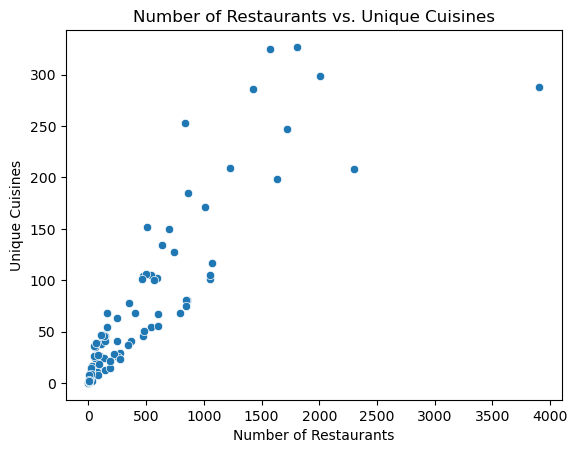

In [24]:
# Count the number of restaurants and unique cuisines per neighborhood
neighborhood_data = (
    df_cleaned.groupby("location")
    .agg(num_restaurants=("name", "count"), unique_cuisines=("cuisines", lambda x: x.nunique()))
    .reset_index()
)

# Scatterplot: Restaurants vs. Unique Cuisines
sns.scatterplot(x="num_restaurants", y="unique_cuisines", data=neighborhood_data)
plt.title("Number of Restaurants vs. Unique Cuisines")
plt.xlabel("Number of Restaurants")
plt.ylabel("Unique Cuisines")
plt.show()

In [29]:
# Reshaping the variables into NumPy arrays and put them into separate objects.
X_1 = neighborhood_data['num_restaurants'].values.reshape(-1,1)
y_1 = neighborhood_data['unique_cuisines'].values.reshape(-1,1)

In [30]:
# Spliting data into a training set and a test set
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.3, random_state=0)

### Regression Analysis

In [27]:
# Creating a regression object
regression_1 = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [31]:
# Fit the regression object onto the training set
regression_1.fit(X_1_train, y_1_train)

LinearRegression()

In [32]:
# Predict the values of y using X
y_1_predicted = regression_1.predict(X_1_test)

In [33]:
# Create the plot in the desired format
plot_test_1 = plt
plot_test_1.scatter(X_1_test, y_1_test, color='gray', s=15)  # Scatter plot for the test set
plot_test_1.plot(X_1_test, y_1_predicted, color='red', linewidth=3)  # Regression line

# Set plot title and labels
plot_test_1.title('Number of Restaurants vs Unique Cuisines (Test Set)')
plot_test_1.xlabel('Number of Restaurants')
plot_test_1.ylabel('Unique Cuisines')

# Show the plot
plot_test_1.show()

The regression line reasonably fits the data, capturing the general upward trend between the number of restaurants and unique cuisines. Most points cluster near the line, indicating a positive correlation; however, there are noticeable deviations, particularly at higher restaurant counts, suggesting variability not fully captured by the model. While the line reflects the overall trend, further analysis, such as calculating the R-squared value, is needed to assess the model's accuracy.

In [34]:
# Creating objects that contain the model summary statistics
rmse_1 = mean_squared_error(y_1_test, y_1_predicted) # This is the mean squared error
r2_1 = r2_score(y_1_test, y_1_predicted) # This is the R2 score. 

In [35]:
# Print the model summary statistics. This is where we evaluate the performance of the model
print('Slope:' ,regression_1.coef_)
print('Mean squared error: ', rmse_1)
print('R2 score: ', r2_1)

Slope: [[0.1126876]]
Mean squared error:  714.6281581702508
R2 score:  0.703811949875325


In [36]:
# Create a dataframe comparing the actual and predicted values of y.
data_1 = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': y_1_predicted.flatten()})
data_1.head(30)

Actual   Predicted
0        0   23.050216
1       37   61.702064
2      104   76.238766
3       68  112.411487
4       35   29.811472
5       41   64.519255
6       46   76.576828
7        9   25.980094
8       51   77.252954
9       12   25.529343
10       2   26.092781
11      27   32.515975
12       2   23.275591
13      54   84.577648
14      46   39.277231
15      13   38.826481
16      26   34.206289
17       4   23.951717
18      14   25.642031
19     101  141.597576
20      81  119.060055
21      68   40.742170
22     209  161.655970
23      75  118.721993
24      15   44.573549
25     117  143.513266
26     171  137.090072
27      47   35.671228
28      41   39.051856

The comparison between actual and predicted values reveals a mix of positive and negative residuals, indicating that the model both overestimates and underestimates certain data points. While some predictions are close to the actual values, there are notable discrepancies, particularly for higher actual values where the residuals tend to be larger. For instance, at an actual value of 209, the predicted value is 161.66, leading to an underestimation by 47.34. Similarly, in cases like an actual value of 101, the prediction overshoots by 40.6. These deviations suggest that while the model captures the general trend, there may be room for improvement in addressing variability, especially for extreme values. Calculating metrics such as Mean Squared Error (MSE) or analyzing patterns in residuals could provide further insights into the model’s performance and areas for refinement.

### Compare how the regression fits the training set

In [37]:
# Predict
y_1_predicted_train = regression_1.predict(X_1_train) # This is predicting X_1_train

In [38]:
rmse_1 = mean_squared_error(y_1_train, y_1_predicted_train)
r2_1 = r2_score(y_1_train, y_1_predicted_train)

In [39]:
# Print the model summary statistics. This is where we evaluate the performance of the model
print('Slope:' ,regression_1.coef_)
print('Mean squared error: ', rmse_1)
print('R2 score: ', r2_1)

Slope: [[0.1126876]]
Mean squared error:  1895.4212066548255
R2 score:  0.7615796861024806


In [41]:
# Visualizing the Training set Results
plot_test_1 = plt
plot_test_1.scatter(X_1_train, y_1_train, color='green', s=15)  # Scatter plot for the train set
plot_test_1.plot(X_1_train, y_1_predicted_train, color='red', linewidth=3)  # Regression line

# Set plot title and labels
plot_test_1.title('Number of Restaurants vs Unique Cuisines (Train Set)')
plot_test_1.xlabel('Number of Restaurants')
plot_test_1.ylabel('Unique Cuisines')

# Show the plot
plot_test_1.show()

When comparing the test and train sets, both reveal a strong positive correlation between the number of restaurants and the variety of unique cuisines. The slopes for both sets are identical (0.1127), indicating a consistent relationship between the variables across the data. The R² score for the test set (0.7038) and the training set (0.7616) suggests that the model performs well in explaining the variability in unique cuisines based on the number of restaurants, though it performs slightly better on the training set. This discrepancy could indicate slight overfitting to the training data.

The mean squared error (MSE) is notably higher for the training set (1895.42) compared to the test set (714.63), which might be attributed to the larger number of data points in the training set or the presence of outliers and extreme values. While the regression line captures the overall trend in both sets, deviations at higher restaurant counts are evident, suggesting that the model's predictions may not be as reliable in extreme cases. Overall, the model demonstrates good performance and generalizability, though fine-tuning might further improve its ability to account for outliers.

### Model Performance on the Test Set

The model's performance on the test set reveals a decent fit, capturing the general trend between the number of restaurants and unique cuisines. However, there are noticeable discrepancies, particularly for higher values of the variables, where residuals tend to be larger. This suggests the model might struggle with extreme cases or regions where the relationship deviates from the overall pattern observed in the training set. While the trend is reasonably well-represented, additional fine-tuning or feature engineering could benefit the prediction accuracy.

### Reflections on Data Bias

Possible data bias could significantly impact the model's performance and its generalizability. For instance, if certain regions or restaurant categories are overrepresented in the dataset, the model might prioritize these patterns at the expense of underrepresented groups. This could explain some of the larger residuals observed in specific test cases. Additionally, factors like regional economic conditions, cultural preferences, or data collection inconsistencies could introduce biases that skew predictions. Addressing this would require a balanced dataset and potentially incorporating additional features to account for such disparities.

## Hypothesis 2:
### If a restaurant has more customer votes, then its average rating will be more reliable and closer to the true quality as perceived by customers.

### Data Prep for Regression Analysis

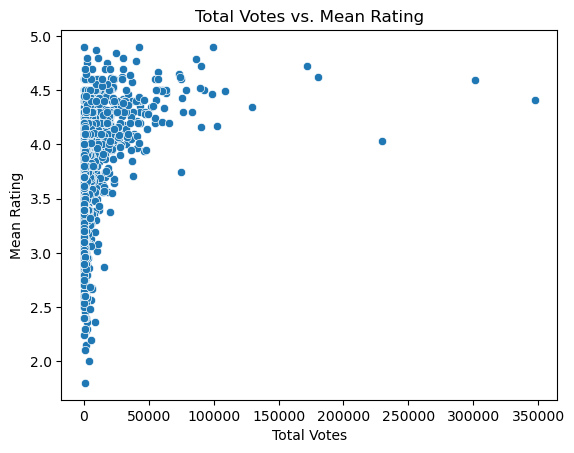

In [49]:
# Count the number of votes and calculate the mean rating for each restaurant
votes_rating_data = (
    df_cleaned.groupby("name")
    .agg(total_votes=("votes", "sum"), mean_rating=("rate", "mean"))
    .reset_index()
)

# Scatterplot: Votes vs. Mean Rating
sns.scatterplot(x="total_votes", y="mean_rating", data=votes_rating_data)
plt.title("Total Votes vs. Mean Rating")
plt.xlabel("Total Votes")
plt.ylabel("Mean Rating")
plt.show()

In [50]:
# Reshaping the variables into NumPy arrays and put them into separate objects.
X_2 = votes_rating_data['total_votes'].values.reshape(-1,1)
y_2 = votes_rating_data['mean_rating'].values.reshape(-1,1)

In [51]:
# Spliting data into a training set and a test set
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=0)

### Regression Analysis

In [52]:
# Creating a regression object
regression_2 = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [53]:
# Fit the regression object onto the training set
regression_2.fit(X_2_train, y_2_train)

LinearRegression()

In [54]:
# Predict the values of y using X
y_2_predicted = regression_2.predict(X_2_test)

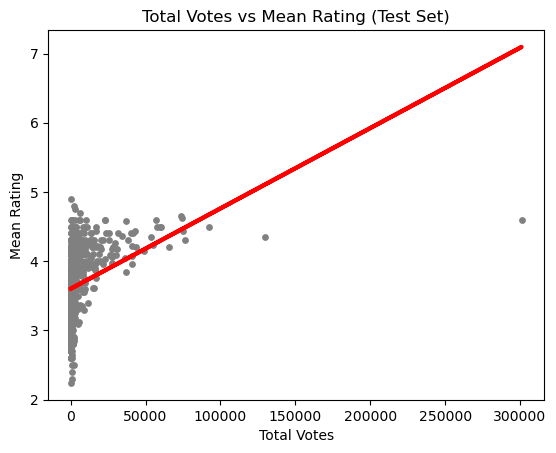

In [55]:
# Create the Plot
plot_test_2 = plt
plot_test_2.scatter(X_2_test, y_2_test, color='gray', s=15)  # Scatter plot for the test set
plot_test_2.plot(X_2_test, y_2_predicted, color='red', linewidth=3)  # Regression line

# Set plot title and labels
plot_test_2.title('Total Votes vs Mean Rating (Test Set)')
plot_test_2.xlabel('Total Votes')
plot_test_2.ylabel('Mean Rating')

# Show the plot
plot_test_2.show()

The scatter plot shows a positive relationship between total votes and average ratings, suggesting that restaurants with more votes tend to have ratings closer to their perceived quality. However, most data points are concentrated around low vote counts, indicating that ratings for less-voted restaurants may be less reliable. The few high-vote restaurants significantly influence the trend, highlighting variability in the relationship.

In [56]:
# Creating objects that contain the model summary statistics
rmse_2 = mean_squared_error(y_2_test, y_2_predicted) # This is the mean squared error
r2_2 = r2_score(y_2_test, y_2_predicted) # This is the R2 score. 

In [57]:
# Print the model summary statistics. This is where we evaluate the performance of the model
print('Slope:' ,regression_2.coef_)
print('Mean squared error: ', rmse_2)
print('R2 score: ', r2_2)

Slope: [[1.16104096e-05]]
Mean squared error:  0.14747699555733937
R2 score:  0.08990684341343547


In [58]:
# Create a dataframe comparing the actual and predicted values of y.
data_2 = pd.DataFrame({'Actual': y_2_test.flatten(), 'Predicted': y_2_predicted.flatten()})
data_2.head(30)

Actual  Predicted
0   3.600000   3.610053
1   3.300000   3.600938
2   3.900000   3.603110
3   4.100000   3.604944
4   3.300000   3.600973
5   3.300000   3.601368
6   3.100000   3.604573
7   3.500000   3.607359
8   2.850000   3.627178
9   3.633333   3.621210
10  3.737500   3.605188
11  3.300000   3.601693
12  3.700000   3.602065
13  2.960000   3.606279
14  3.900000   3.602785
15  3.600000   3.601577
16  3.300000   3.600950
17  3.400000   3.601020
18  3.800000   3.608590
19  3.000000   3.600950
20  3.400000   3.600950
21  4.087097   3.647136
22  3.600000   3.602726
23  3.900000   3.608566
24  4.000000   3.614012
25  3.566667   3.610912
26  3.700000   3.605989
27  3.900000   3.602355
28  3.600000   3.604038
29  3.900000   3.609588

The comparison between actual and predicted average ratings reveals a minimal variance, as the predicted values consistently hover close to 3.6 regardless of the actual values. The slope of the regression line is minimal (approximately 0.000011), indicating that the model predicts minimal variation in ratings based on the independent variable (total votes). This is further reflected in the low R² score of 0.0899, suggesting that the model explains only about 8.99% of the variance in the ratings. Additionally, the mean squared error (MSE) of 0.1475 highlights a relatively small error magnitude, but it is clear that the model does not capture the relationship between votes and ratings effectively. This suggests that while the predicted ratings are close to the overall average rating, the model struggles to capture individual variations, indicating a weak predictive power for this hypothesis.

### Compare how the regression fits the training set

In [59]:
# Predict
y_2_predicted_train = regression_2.predict(X_2_train) # This is predicting X_2_train

In [60]:
rmse_2 = mean_squared_error(y_2_train, y_2_predicted_train)
r2_2 = r2_score(y_2_train, y_2_predicted_train)

In [61]:
# Print the model summary statistics. This is where we evaluate the performance of the model
print('Slope:' ,regression_2.coef_)
print('Mean squared error: ', rmse_2)
print('R2 score: ', r2_2)

Slope: [[1.16104096e-05]]
Mean squared error:  0.15159949325290245
R2 score:  0.08159557363872261


In [62]:
# Visualizing the Training set Results
plot_test_2 = plt
plot_test_2.scatter(X_2_train, y_2_train, color='green', s=15)  # Scatter plot for the train set
plot_test_2.plot(X_2_train, y_2_predicted_train, color='red', linewidth=3)  # Regression line

# Set plot title and labels
plot_test_2.title('Total Votes vs Mean Rating (Train Set)')
plot_test_2.xlabel('Total Votes')
plot_test_2.ylabel('Mean Rating')

# Show the plot
plot_test_2.show()

Comparing the insights from the training and test sets, both show a weak relationship between total votes and mean ratings, with the regression line indicating a minimal positive slope (training slope: 0.000011). In the test set, the R² score (0.0899) is slightly higher than in the training set (0.0816), but both remain low, showing that total votes explain only a small fraction of the variance in mean ratings for both sets. The mean squared error (MSE) for the test set (0.1475) is slightly better than for the training set (0.1516), indicating marginally more accurate predictions for the test data.

The scatterplots for both sets reveal similar clustering patterns, with most restaurants receiving low vote counts, and only a few outliers with very high votes affecting the regression line. These outliers influence the slope without significantly improving the model's prediction of mean ratings. This comparison highlights that the weak relationship observed in the training set generalizes to the test set, confirming that total votes are not a strong predictor of the reliability of mean ratings in this dataset.

### Model Performance on Test Set:

The regression model for the test set indicates a very weak relationship between total votes and average ratings, as reflected by a low R² score of 0.0899. This suggests that the number of votes explains only about 9% of the variance in the average ratings, meaning the model does not effectively predict the ratings based on the total number of votes. The slope of the regression line (1.161e-05) is very small, further indicating that the impact of the number of votes on the ratings is minimal.

The mean squared error (MSE) of 0.1474 suggests that the model’s predictions have some level of error, but the relatively low value indicates it may still capture some trend. However, the low R² value and small slope suggest the model does not provide strong predictions. The scatter plot further shows that the data points are heavily concentrated around low vote counts, with only a few higher vote-count restaurants influencing the overall trend. This may point to a potential bias in the data, where less-voted restaurants may have less reliable ratings, which the model struggles to account for.

### Reflections on Possible Data Bias:

One significant concern with this analysis is the skewed distribution of votes. The majority of restaurants in the dataset have relatively low total votes, and these points dominate the regression analysis. This concentration near lower vote counts could lead to a model that does not generalize well, especially for higher-voted restaurants, whose ratings may better reflect customer sentiment and quality. The model appears to be biased towards the behaviour of restaurants with lower votes, possibly underestimating the reliability of ratings for popular establishments with higher vote counts. To improve the model's predictive power, it may be useful to explore weighted regression techniques or consider transformations that address this imbalance in the dataset.